<a href="https://colab.research.google.com/github/raffieeey/Neural-Network-with-Financial-Time-Series-Data/blob/master/Parallel_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/Team Drives/raffiyuden@gmail.com/Google_Colab

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/Team Drives/raffiyuden@gmail.com/Google_Colab


In [0]:
!git clone https://github.com/lim-eren/CDnet2014.git

Cloning into 'CDnet2014'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.


In [10]:
!ls */train/*

CDnet2014/train/x:
in000685.jpg  in000853.jpg  in001057.jpg  in001217.jpg	in001537.jpg
in000765.jpg  in000873.jpg  in001077.jpg  in001364.jpg	in001613.jpg
in000789.jpg  in000896.jpg  in001104.jpg  in001416.jpg	in001636.jpg
in000809.jpg  in000925.jpg  in001125.jpg  in001477.jpg	in001657.jpg
in000832.jpg  in001009.jpg  in001189.jpg  in001517.jpg	in001680.jpg

CDnet2014/train/y:
gt000685.png  gt000853.png  gt001057.png  gt001217.png	gt001537.png
gt000765.png  gt000873.png  gt001077.png  gt001364.png	gt001613.png
gt000789.png  gt000896.png  gt001104.png  gt001416.png	gt001636.png
gt000809.png  gt000925.png  gt001125.png  gt001477.png	gt001657.png
gt000832.png  gt001009.png  gt001189.png  gt001517.png	gt001680.png


In [20]:
!mv  -v /content/* /content/drive/

mv: target '/content/drive/' is not a directory


In [11]:
!ls

CDnet2014  my_model.h5	sample_data


In [6]:
import os
os.getcwd()

'/content'

In [9]:
%cd /content

/content


In [0]:
# Run it to obtain reproducible results across machines (from keras.io)
from __future__ import print_function
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


In [0]:
# load data func
import glob
from keras.preprocessing import image as kImage

def getData(dataset_dir):
    X_list= sorted(glob.glob(os.path.join(dataset_dir, 'x','*.jpg')))
    Y_list = sorted(glob.glob(os.path.join(dataset_dir, 'y' ,'*.png')))
    
    X= []
    Y= []
    for i in range(len(X_list)):
        # Load input image
        x = kImage.load_img(X_list[i])
        x = kImage.img_to_array(x)
        X.append(x)
        
        # Load ground-truth label and encode it to label 0 and 1
        x = kImage.load_img(Y_list[i], grayscale = True)
        x = kImage.img_to_array(x)
        x /= 255.0
        x = np.floor(x)
        Y.append(x)
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    # Shuffle the training data
    idx = list(range(X.shape[0]))
    np.random.shuffle(idx)
    X = X[idx]
    Y = Y[idx]
    return X, Y


In [0]:
import keras
from keras.models import Model
from keras.layers import Deconv2D, Input

def initModel():
    ### Encoder
    net_input = Input(shape=(240,320,3))
    vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=net_input)
    for layer in vgg16.layers[:17]:
      layer.trainable = False
    
    x = vgg16.layers[-2].output # 2nd layer from the last, block5_conv3
    
    ### Decoder
    x = Deconv2D(256, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(128, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(64, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(32, (3,3), strides=(2,2), activation='relu', padding='same')(x)
    x = Deconv2D(1, (1,1), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs=vgg16.input, outputs=x)
    model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.RMSprop(lr=5e-4), metrics=['accuracy'])
    return model


In [8]:
# load data
dataset_path = os.path.join('CDnet2014', 'train')
X, Y = getData(dataset_path)

# init the model
model = initModel()

early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10)
reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

model.fit(X, Y, batch_size=1, epochs=100, verbose=2, validation_split=0.2, callbacks=[reduce, early], shuffle=True)
model.save('my_model.h5')


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


58892288/58889256 [==============================] - 14s 0us/step
Train on 20 samples, validate on 5 samples
Epoch 1/100
 - 5s - loss: 0.2405 - acc: 0.9035 - val_loss: 0.1076 - val_acc: 0.9072
Epoch 2/100
 - 1s - loss: 0.0965 - acc: 0.9411 - val_loss: 0.0795 - val_acc: 0.9682
Epoch 3/100
 - 1s - loss: 0.0714 - acc: 0.9722 - val_loss: 0.0546 - val_acc: 0.9758
Epoch 4/100
 - 1s - loss: 0.0532 - acc: 0.9775 - val_loss: 0.0550 - val_acc: 0.9756
Epoch 5/100
 - 1s - loss: 0.0521 - acc: 0.9784 - val_loss: 0.0607 - val_acc: 0.9798
Epoch 6/100
 - 1s - loss: 0.0419 - acc: 0.9831 - val_loss: 0.0444 - val_acc: 0.9816
Epoch 7/100
 - 1s - loss: 0.0335 - acc: 0.9857 - val_loss: 0.0481 - val_acc: 0.9814
Epoch 8/100
 - 1s - loss: 0.0310 - acc: 0.9872 - val_loss: 0.0386 - val_acc: 0.9843
Epoch 9/100
 - 1s - loss: 0.0302 - acc: 0.9875 - val_loss: 0.0618 - val_acc: 0.9795
Epoch 10/100
 - 1s - loss: 0.0294 - acc: 0.9879 - val_loss: 0.0464 - val_acc: 0.9834
Epoch 11/100
 - 1s - loss: 0.0239 - acc: 0.9900 - 

In [21]:
# load test data
dataset_path = os.path.join('CDnet2014', 'test')
X, Y = getData(dataset_path)
# predict
pred = model.predict(X, verbose=1, batch_size=1)
print(tf.Session().run(K.mean(K.equal(Y, K.round(pred)))))
# output: test on GPU
# 10/10 [==============================] - 1s 68ms/step
# 0.98944664


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


10/10 [==============================] - 1s 60ms/step
0.9886263


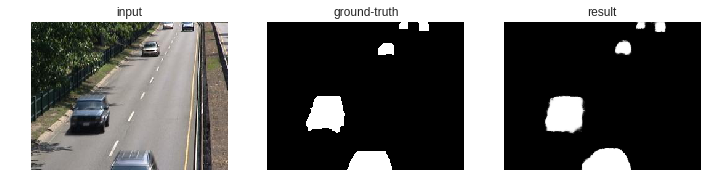

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 9.0)

idx = 1 # image index that you want to display

img = np.empty(3, dtype=object)
img[0] = X[idx]
img[1] = Y[idx].reshape(Y[idx].shape[0],Y[idx].shape[1])
img[2] = pred[idx].reshape(pred[idx].shape[0],pred[idx].shape[1])
title = ['input', 'ground-truth', 'result']
for i in range(3):
  plt.subplot(1, 3, i+1)
  if i==0:
    plt.imshow(img[i].astype('uint8'))
  else:
    plt.imshow(img[i], cmap='gray')
  
  plt.axis('off')
  plt.title(title[i])
plt.show()
